# QC: preprocess, filtering, normalization, log tansform

### Documention

In [11]:
# https://nbisweden.github.io/excelerate-scRNAseq/session-qc/Quality_control.html

## Load packages

In [7]:
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import scrublet as scr
import numpy as np
import matplotlib.pyplot as plt
import mygene

In [3]:
import pickle

## Load the h5ad Data Object containing the counts and annotations

In [2]:
combined_adata = ad.read_h5ad('/storage/users/data/PANC/H5AD_file/combined_adata.h5ad')

In [3]:
print(combined_adata.obs['condition'])

barcode
AAACCCAGTAGGCTCC-1         CTRL_1
AAACCCAGTCGCAACC-1         CTRL_1
AAACCCATCCACAAGT-1         CTRL_1
AAACGCTTCACTACGA-1         CTRL_1
AAACGCTTCAGCCTCT-1         CTRL_1
                         ...     
TTTACTGTCATTACTC-1    TGFb1_GEM_2
TTTCACAGTGATATAG-1    TGFb1_GEM_2
TTTCACATCGATGCAT-1    TGFb1_GEM_2
TTTCATGTCCCTCTAG-1    TGFb1_GEM_2
TTTGACTGTTCCGGTG-1    TGFb1_GEM_2
Name: condition, Length: 11919, dtype: category
Categories (8, object): ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']


In [4]:
print(combined_adata)

AnnData object with n_obs × n_vars = 11919 × 36613
    obs: 'condition'


## QC: preprocess, filtering, normalization

### Filter: CMO tags

In [5]:
# Identify CMO tags (or other spike-ins)
combined_adata.var["CMO"] = combined_adata.var_names.str.contains("CMO")

In [6]:
# Get Percentage of CMOs in cells
# Filter the Data for CMO Tags
cmo_data = combined_adata[:, combined_adata.var["CMO"].values].X
# Calculate the Percentage:
cmo_counts_per_cell = cmo_data.sum(axis=1)
total_counts_per_cell = combined_adata.X.sum(axis=1)
pct_cmo_per_cell = (cmo_counts_per_cell / total_counts_per_cell) * 100
# Add to the obs DataFrame:
combined_adata.obs["pct_cmo"] = pct_cmo_per_cell
print(combined_adata.obs["pct_cmo"])

barcode
AAACCCAGTAGGCTCC-1    24.628355
AAACCCAGTCGCAACC-1    34.891727
AAACCCATCCACAAGT-1    23.580470
AAACGCTTCACTACGA-1    23.367459
AAACGCTTCAGCCTCT-1    24.847910
                        ...    
TTTACTGTCATTACTC-1    29.620835
TTTCACAGTGATATAG-1    12.793065
TTTCACATCGATGCAT-1    50.637605
TTTCATGTCCCTCTAG-1    46.113246
TTTGACTGTTCCGGTG-1    31.137191
Name: pct_cmo, Length: 11919, dtype: float64


#### Remove CMO tags

In [7]:
combined_adata.var["CMO"]

feature_id
ENSG00000243485    False
ENSG00000237613    False
ENSG00000186092    False
ENSG00000238009    False
ENSG00000239945    False
                   ...  
CMO308              True
CMO309              True
CMO310              True
CMO311              True
CMO312              True
Name: CMO, Length: 36613, dtype: bool

In [8]:
combined_adata = combined_adata[:, ~combined_adata.var["CMO"].values]

In [9]:
combined_adata.var["CMO"]

feature_id
ENSG00000243485    False
ENSG00000237613    False
ENSG00000186092    False
ENSG00000238009    False
ENSG00000239945    False
                   ...  
ENSG00000277836    False
ENSG00000278633    False
ENSG00000276017    False
ENSG00000278817    False
ENSG00000277196    False
Name: CMO, Length: 36601, dtype: bool

In [10]:
combined_adata

View of AnnData object with n_obs × n_vars = 11919 × 36601
    obs: 'condition', 'pct_cmo'
    var: 'CMO'

### Calculate several QC metrics that will be stored in the adata Object

In [11]:
sc.pp.calculate_qc_metrics(combined_adata, inplace=True)
print(combined_adata)

/home/s468630/micromamba/envs/scAnalysis/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 11919 × 36601
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


### Filter: Mitochondrial and Ribosomal Genes

#### Create dictionary ensembl2symbol

In [19]:
from biomart import BiomartServer

# Connect to the BioMart server
server = BiomartServer("http://ensembl.org/biomart")

# Select the human genes dataset
dataset = server.datasets['hsapiens_gene_ensembl']

# Query BioMart to get the translation from Ensembl ID to gene symbol
response = dataset.search({
    'attributes': ['ensembl_gene_id', 'external_gene_name'],
})

# Initialize an empty dictionary to store the mapping
ensembl_to_gene_name = {}

# Iterate through the response lines
for line in response.iter_lines():
    # Decode the line and split it into Ensembl ID and gene name
    decoded_line = line.decode('utf-8')
    ensembl_id, gene_name = decoded_line.split('\t')
    
    # Store the mapping in the dictionary
    ensembl_to_gene_name[ensembl_id] = gene_name

# Now, ensembl_to_gene_name is a dictionary with Ensembl IDs as keys and gene names as values.


In [23]:
# Save adata --> here ID ensg number_for pseudotime


with open("data/ensembl_to_gene_name.pkl", "wb") as f:
    pickle.dump(ensembl_to_gene_name, f)

In [17]:
with open("ensembl_to_gene_name.pkl", "rb") as f:
    ensembl_to_gene_name = pickle.load(f)

In [18]:
ensembl_to_gene_name

{'ENSG00000210049': 'MT-TF',
 'ENSG00000211459': 'MT-RNR1',
 'ENSG00000210077': 'MT-TV',
 'ENSG00000210082': 'MT-RNR2',
 'ENSG00000209082': 'MT-TL1',
 'ENSG00000198888': 'MT-ND1',
 'ENSG00000210100': 'MT-TI',
 'ENSG00000210107': 'MT-TQ',
 'ENSG00000210112': 'MT-TM',
 'ENSG00000198763': 'MT-ND2',
 'ENSG00000210117': 'MT-TW',
 'ENSG00000210127': 'MT-TA',
 'ENSG00000210135': 'MT-TN',
 'ENSG00000210140': 'MT-TC',
 'ENSG00000210144': 'MT-TY',
 'ENSG00000198804': 'MT-CO1',
 'ENSG00000210151': 'MT-TS1',
 'ENSG00000210154': 'MT-TD',
 'ENSG00000198712': 'MT-CO2',
 'ENSG00000210156': 'MT-TK',
 'ENSG00000228253': 'MT-ATP8',
 'ENSG00000198899': 'MT-ATP6',
 'ENSG00000198938': 'MT-CO3',
 'ENSG00000210164': 'MT-TG',
 'ENSG00000198840': 'MT-ND3',
 'ENSG00000210174': 'MT-TR',
 'ENSG00000212907': 'MT-ND4L',
 'ENSG00000198886': 'MT-ND4',
 'ENSG00000210176': 'MT-TH',
 'ENSG00000210184': 'MT-TS2',
 'ENSG00000210191': 'MT-TL2',
 'ENSG00000198786': 'MT-ND5',
 'ENSG00000198695': 'MT-ND6',
 'ENSG00000210194': 

In [19]:
print(f"Number of cells with no detected genes: {(combined_adata.X.sum(axis=1) == 0).sum()}")

Number of cells with no detected genes: 0


#### Add gene symbol to combined_adata object

##### Annotate Gene Symbol

In [20]:
# Assuming ensembl_to_gene_name is a dictionary where the keys are Ensembl IDs and the values are gene symbols
combined_adata.var["gene_symbol"] = combined_adata.var_names.map(ensembl_to_gene_name)

In [21]:
combined_adata.var["gene_symbol"]

feature_id
ENSG00000243485    MIR1302-2HG
ENSG00000237613        FAM138A
ENSG00000186092          OR4F5
ENSG00000238009            NaN
ENSG00000239945               
                      ...     
ENSG00000277836               
ENSG00000278633               
ENSG00000276017               
ENSG00000278817               
ENSG00000277196               
Name: gene_symbol, Length: 36601, dtype: object

##### Fill empty Symbols with Ensembl IDs

In [22]:
combined_adata.var["ensembl_gene_id"] = combined_adata.var_names.astype(str)
combined_adata.var["gene_symbol"].fillna(combined_adata.var["ensembl_gene_id"], inplace=True)
print("Remaining NaN in 'gene_symbol':", combined_adata.var["gene_symbol"].isna().sum())


Remaining NaN in 'gene_symbol': 0


In [23]:
combined_adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601',
       ...
       'ENSG00000274175', 'ENSG00000275869', 'ENSG00000273554',
       'ENSG00000278782', 'ENSG00000277761', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', name='feature_id', length=36601)

In [24]:
combined_adata.var["gene_symbol"]

feature_id
ENSG00000243485        MIR1302-2HG
ENSG00000237613            FAM138A
ENSG00000186092              OR4F5
ENSG00000238009    ENSG00000238009
ENSG00000239945                   
                        ...       
ENSG00000277836                   
ENSG00000278633                   
ENSG00000276017                   
ENSG00000278817                   
ENSG00000277196                   
Name: gene_symbol, Length: 36601, dtype: object

In [25]:
combined_adata

AnnData object with n_obs × n_vars = 11919 × 36601
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id'

#### Analyze Mito and Ribo Genes

In [26]:
# After loading your data, identify mitochondrial and ribosomal genes
#combined_adata.var["mito"] = combined_adata.var_names.str.startswith("MT-") | combined_adata.var_names.str.startswith("mt-")
#combined_adata.var["ribo"] = combined_adata.var_names.str.startswith("RPS") | combined_adata.var_names.str.startswith("RPL")

# Using the gene_symbol column to identify mitochondrial and ribosomal genes
combined_adata.var["mito"] = combined_adata.var["gene_symbol"].str.startswith("MT-") | combined_adata.var["gene_symbol"].str.startswith("mt-")
combined_adata.var["ribo"] = combined_adata.var["gene_symbol"].str.startswith("RPS") | combined_adata.var["gene_symbol"].str.startswith("RPL")


#### Compute QC metrics, considering both mitochondrial and ribosomal genes

In [27]:
# Compute QC metrics, considering both mitochondrial and ribosomal genes
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=["mito", "ribo"], percent_top=None, inplace=True)

In [28]:
# Get a list of the newly annotated adata object and the Mitochondrial count
print(combined_adata)
combined_adata.obs.pct_counts_mito


AnnData object with n_obs × n_vars = 11919 × 36601
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo'


barcode
AAACCCAGTAGGCTCC-1    2.144417
AAACCCAGTCGCAACC-1    1.871827
AAACCCATCCACAAGT-1    1.433304
AAACGCTTCACTACGA-1    2.549500
AAACGCTTCAGCCTCT-1    2.505463
                        ...   
TTTACTGTCATTACTC-1    2.388475
TTTCACAGTGATATAG-1    2.521221
TTTCACATCGATGCAT-1    1.648956
TTTCATGTCCCTCTAG-1    1.987448
TTTGACTGTTCCGGTG-1    1.839445
Name: pct_counts_mito, Length: 11919, dtype: float64

In [29]:
# Sort the cells by Percentage Mitochondrium and order by highest percentage first
sorted_adata = combined_adata[combined_adata.obs['pct_counts_mito'].sort_values(ascending=False).index]
sorted_adata.obs.pct_counts_mito

barcode
TCCCAGTGTATTAAGG-1    96.745152
TATTGGGGTAGGAAAG-1    96.578906
TCATTACCACGACGCT-1    95.793935
TACCCGTTCCGAGGCT-1    95.497111
GACCGTGCACGCTTAA-1    95.034890
                        ...    
ACAAGCTTCGTTCTCG-1     0.033714
TTGTTTGAGAGTGTTA-1     0.027454
GTGGGAATCGAGTTGT-1     0.025947
TCCTGCACATTGAAAG-1     0.011808
CATACCCTCAACTCTT-1     0.011618
Name: pct_counts_mito, Length: 11919, dtype: float64

#### Visualize cell's mitchondrial and ribosomal gene expression

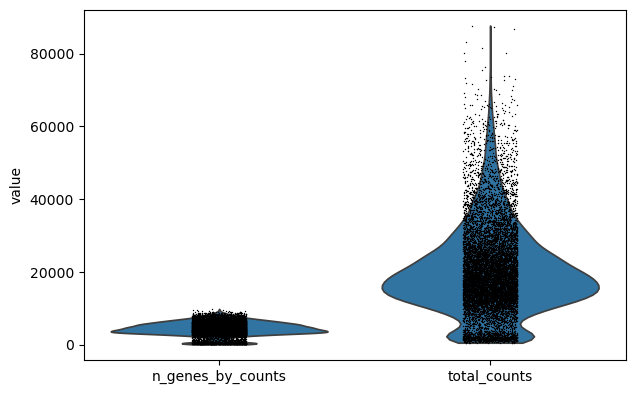

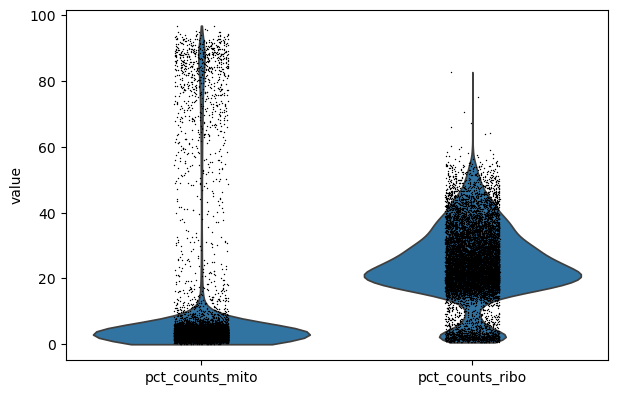

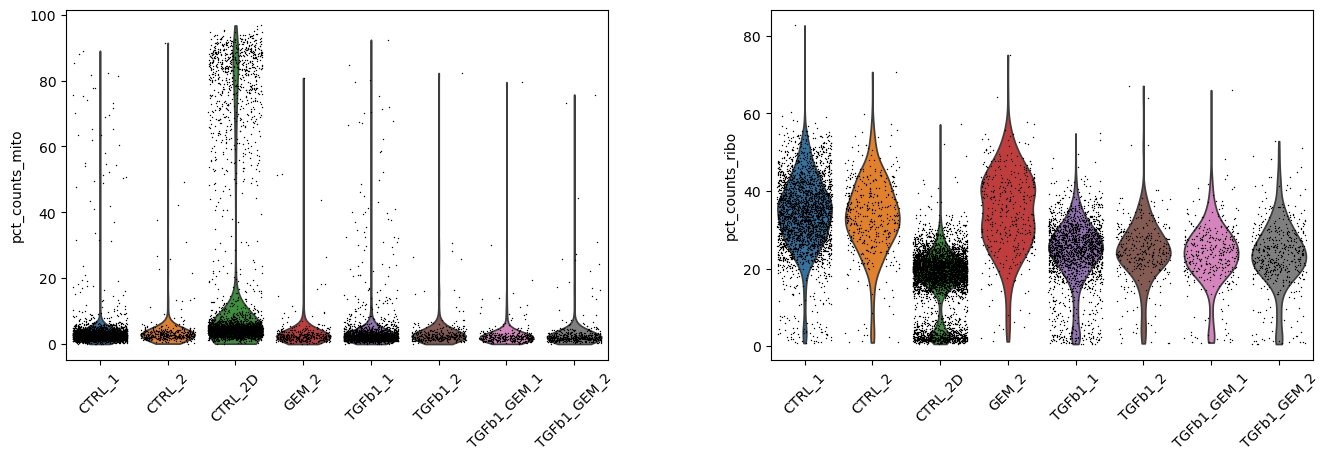

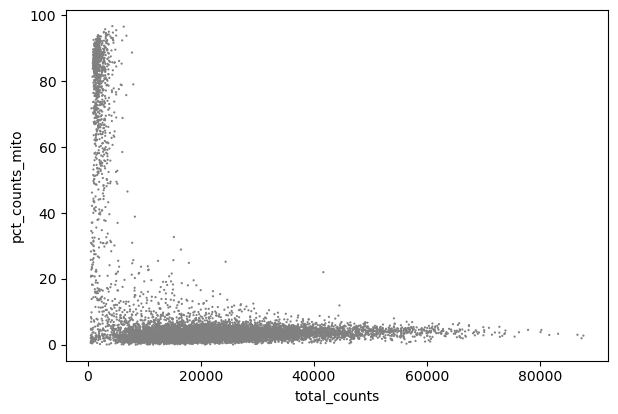

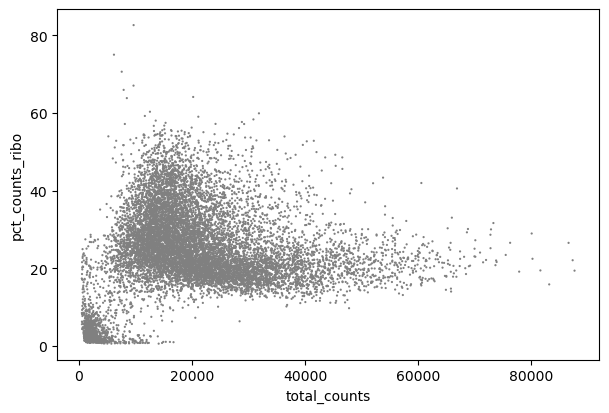

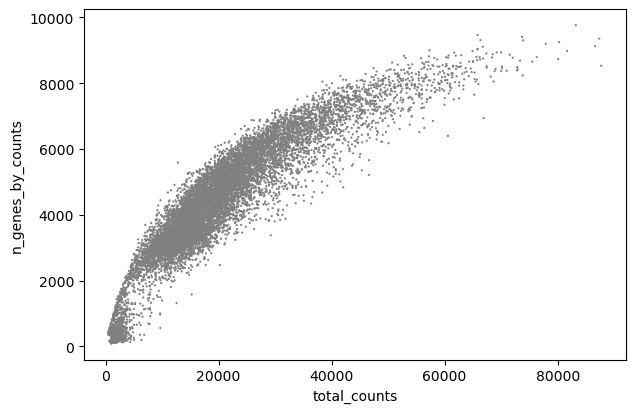

In [30]:
# Visualize basic QC metrics, including ribosomal content:
sc.pl.violin(combined_adata, ['n_genes_by_counts', 'total_counts'])
sc.pl.violin(combined_adata, ['pct_counts_mito','pct_counts_ribo'])
import scanpy as sc

sc.pl.violin(
    combined_adata,
    keys=['pct_counts_mito', 'pct_counts_ribo'],
    groupby='condition',
    jitter=0.4,
    rotation=45,
    stripplot=True,
    multi_panel=True,
    save='violin_mito_ribo.png'  # Save the plot as an image
)
plt.show()

sc.pl.scatter(combined_adata, x='total_counts', y='pct_counts_mito')
sc.pl.scatter(combined_adata, x='total_counts', y='pct_counts_ribo')
sc.pl.scatter(combined_adata, x='total_counts', y='n_genes_by_counts')

#### Filter Mito and Ribo according to a certain percentage (e.g. 10 and 50%)

##### Delete faulty ribo/mito: Old logic to filter over all conditions

In [31]:
combined_adata.obs['condition']

barcode
AAACCCAGTAGGCTCC-1         CTRL_1
AAACCCAGTCGCAACC-1         CTRL_1
AAACCCATCCACAAGT-1         CTRL_1
AAACGCTTCACTACGA-1         CTRL_1
AAACGCTTCAGCCTCT-1         CTRL_1
                         ...     
TTTACTGTCATTACTC-1    TGFb1_GEM_2
TTTCACAGTGATATAG-1    TGFb1_GEM_2
TTTCACATCGATGCAT-1    TGFb1_GEM_2
TTTCATGTCCCTCTAG-1    TGFb1_GEM_2
TTTGACTGTTCCGGTG-1    TGFb1_GEM_2
Name: condition, Length: 11919, dtype: category
Categories (8, object): ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']

##### Not used!!: Delete faulty ribo/mito: new logic to filter conditions wise

In [32]:
import numpy as np
import scanpy as sc

# Recalculate QC metrics if needed
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=["mito", "ribo"], percent_top=None, inplace=True)

# Initialize lists to store percentile thresholds for each condition
mito_thresholds = {}
ribo_thresholds = {}

# Calculate percentiles per condition
for condition in combined_adata.obs['condition'].unique():
    # Subset data for the current condition
    condition_data = combined_adata.obs[combined_adata.obs['condition'] == condition]

    if condition_data.shape[0] == 0:
        print(f"Skipping condition: {condition} (no cells)")
        continue

    # Calculate percentiles
    mito_upper = np.percentile(condition_data['pct_counts_mito'], 90)
    ribo_lower = np.percentile(condition_data['pct_counts_ribo'], 5)
    ribo_upper = np.percentile(condition_data['pct_counts_ribo'], 90)

    # Store thresholds for reference
    mito_thresholds[condition] = mito_upper
    ribo_thresholds[condition] = (ribo_lower, ribo_upper)

    print(f"{condition}: mito_upper={mito_upper:.2f}, ribo_lower={ribo_lower:.2f}, ribo_upper={ribo_upper:.2f}")

# Apply filtering
filtered_adata = combined_adata[
    combined_adata.obs.apply(
        lambda x: (
            x['pct_counts_mito'] <= mito_thresholds[x['condition']] and
            ribo_thresholds[x['condition']][0] <= x['pct_counts_ribo'] <= ribo_thresholds[x['condition']][1]
        ),
        axis=1
    ),
    :
]

print(f"Filtered data shape: {filtered_adata.shape}")

CTRL_1: mito_upper=4.83, ribo_lower=20.42, ribo_upper=45.52
CTRL_2: mito_upper=4.83, ribo_lower=18.43, ribo_upper=44.22
CTRL_2D: mito_upper=78.24, ribo_lower=1.84, ribo_upper=24.66
GEM_2: mito_upper=4.69, ribo_lower=17.72, ribo_upper=47.59
TGFb1_1: mito_upper=5.16, ribo_lower=4.94, ribo_upper=32.69
TGFb1_2: mito_upper=5.04, ribo_lower=9.19, ribo_upper=33.12
TGFb1_GEM_1: mito_upper=3.85, ribo_lower=7.15, ribo_upper=31.51
TGFb1_GEM_2: mito_upper=4.25, ribo_lower=6.27, ribo_upper=32.99
Filtered data shape: (9383, 36601)


In [33]:
# Filter cells based on mitochondrial and ribosomal content:
# Cells with high mitochondrial gene expression might be undergoing apoptosis, so you might want to exclude them.
sc.pp.calculate_qc_metrics(filtered_adata, qc_vars=["mito", "ribo"], percent_top=None, inplace=True)
filtered_adata = filtered_adata[filtered_adata.obs.pct_counts_mito < 10, :]
# high levels of ribosomal RNA (rRNA) can indicate incomplete poly-A tail capture or contamination. Thus, by filtering out cells with excessive ribosomal transcripts, we're likely removing lower-quality cells.
filtered_adata = filtered_adata[filtered_adata.obs.pct_counts_ribo < 45, :]

/home/s468630/micromamba/envs/scAnalysis/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


#### Redefine object according to which mito and ribo filter method used

In [34]:
filtered_combined_adata = filtered_adata.copy()
#filtered_combined_adata = combined_adata.copy()

#### View and evaluate filtering

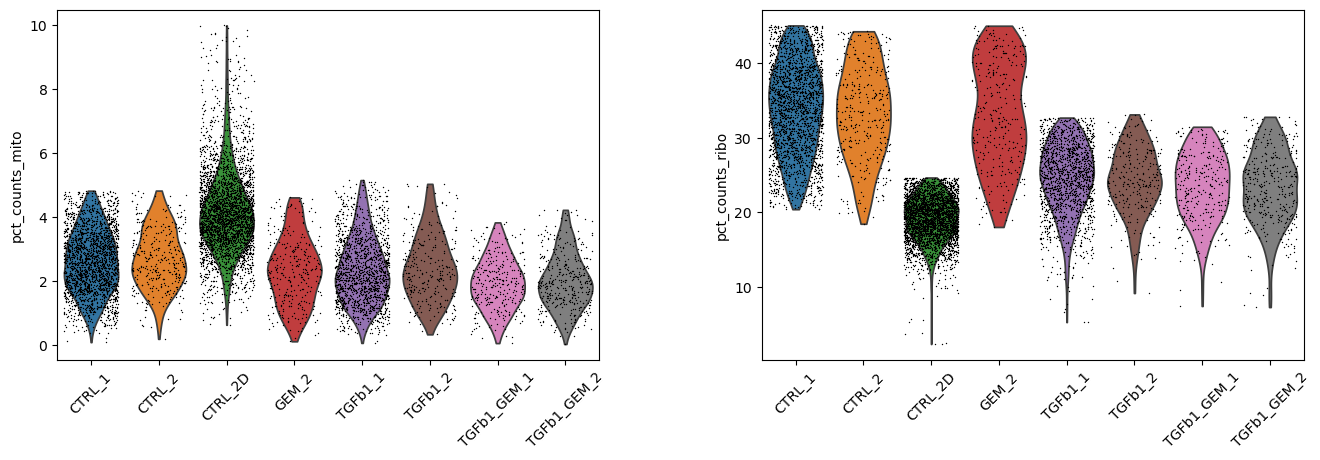

In [35]:
sc.pp.calculate_qc_metrics(filtered_combined_adata, qc_vars=["mito", "ribo"], percent_top=None, inplace=True)
sc.pl.violin(
    filtered_combined_adata,
    keys=['pct_counts_mito', 'pct_counts_ribo'],
    groupby='condition',
    jitter=0.4,
    rotation=45,
    stripplot=True,
    multi_panel=True,
    save='violin_mito_ribo.png'  # Save the plot as an image
)
plt.show()


In [36]:
combined_adata

AnnData object with n_obs × n_vars = 11919 × 36601
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo'
    uns: 'condition_colors'

In [37]:
filtered_combined_adata

AnnData object with n_obs × n_vars = 8992 × 36601
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo'
    uns: 'condition_colors'

### Filter: Min and max gene count per cell filtering

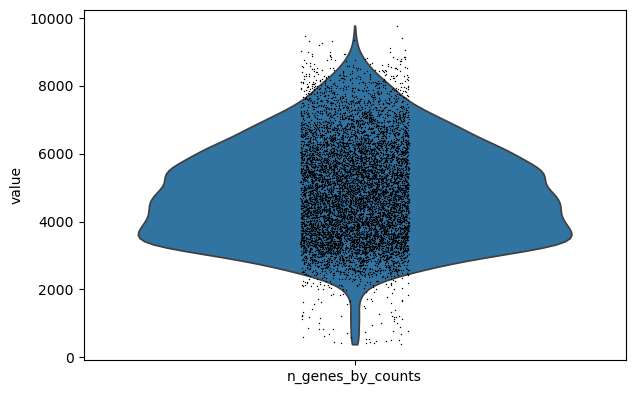

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

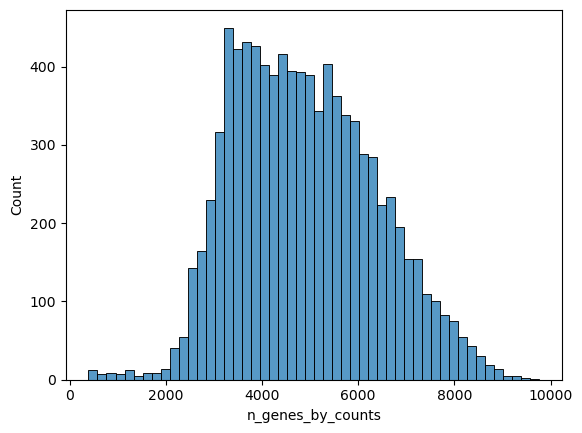

In [38]:
# Visualize the number of genes per cell
sc.pl.violin(filtered_combined_adata, keys=['n_genes_by_counts'], jitter=True, log=False)

import seaborn as sns
sns.histplot(filtered_combined_adata.obs['n_genes_by_counts'], bins=50)

In [39]:
# Set thresholds based on the previous scatter plots, removing low-quality cells and potential doublets.
mincount = 1900;
maxcount = 9000;

# Optional 
#mincount = combined_adata.obs['n_genes_by_counts'].quantile(0.01)
#maxcount = combined_adata.obs['n_genes_by_counts'].quantile(0.99)

In [40]:
#sc.pp.filter_cells(combined_adata, min_counts=1000)
filtered_combined_adata = filtered_combined_adata[filtered_combined_adata.obs.n_genes_by_counts > mincount, :]
filtered_combined_adata = filtered_combined_adata[filtered_combined_adata.obs.n_genes_by_counts < maxcount, :]

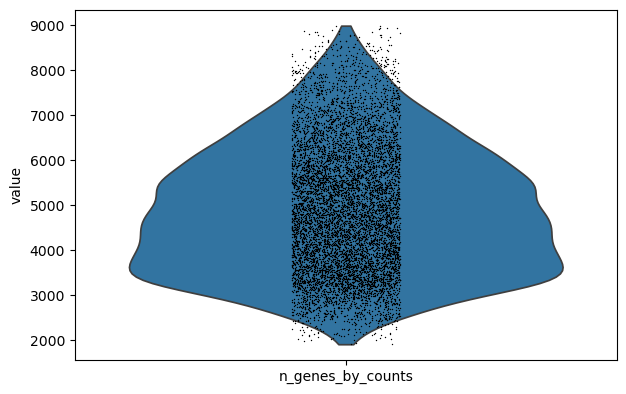

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

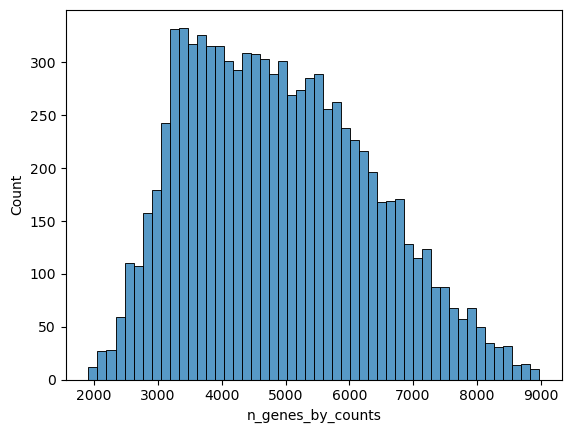

In [41]:
sc.pl.violin(filtered_combined_adata, keys=['n_genes_by_counts'], jitter=True, log=False)
sns.histplot(filtered_combined_adata.obs['n_genes_by_counts'], bins=50)

In [42]:
filtered_combined_adata

View of AnnData object with n_obs × n_vars = 8911 × 36601
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo'
    uns: 'condition_colors'

### Filter: Min and max total transcript count per cell filtering

In [43]:
# filtering based on total_counts is also common in single-cell RNA sequencing (scRNA-seq) quality control, and it's analogous to filtering based on n_genes_by_counts.
# Why Apply Min and Max Cutoffs on total_counts?
## Low-quality cells: Cells with very low total_counts can indicate cells with poor-quality RNA, dying cells, or cells with limited RNA content. They might also represent empty droplets or ambient RNA in droplet-based technologies like 10x Genomics.
## Doublets or Multiplets: An abnormally high total_counts might indicate doublets or multiplets, where two or more cells got captured together.
## Standardizing Sequencing Depth: While downstream normalization methods often account for differences in sequencing depth, extreme outliers can still introduce biases.

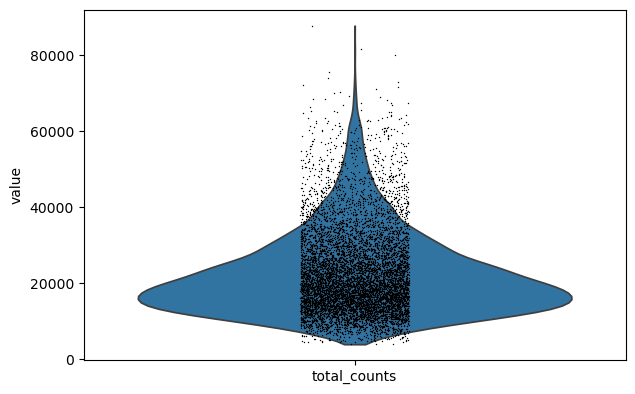

<Axes: xlabel='total_counts', ylabel='Count'>

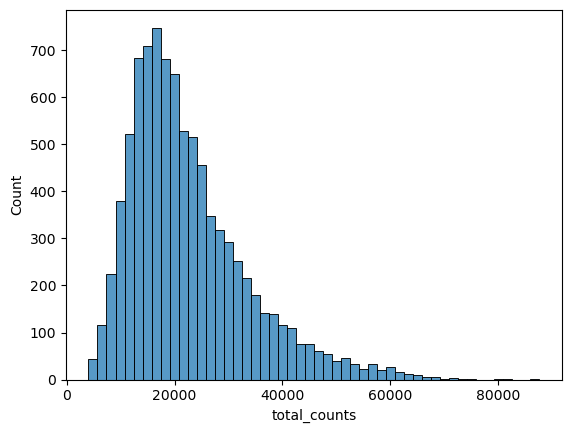

In [44]:
# Histogram or Violin Plot: A visual inspection can help identify outliers or bimodal distributions.
sc.pl.violin(filtered_combined_adata, keys=['total_counts'], jitter=True, log=False)
    
import seaborn as sns
sns.histplot(filtered_combined_adata.obs['total_counts'], bins=50)

In [45]:
mincount = 0; 
maxcount = 70000; 
#alternative
#mincount = filtered_combined_adata.obs['total_counts'].quantile(0.01)
#maxcount = filtered_combined_adata.obs['total_counts'].quantile(0.99)

In [46]:
#sc.pp.filter_cells(combined_adata, min_counts=1000)
filtered_combined_adata = filtered_combined_adata[filtered_combined_adata.obs.total_counts > mincount, :]
filtered_combined_adata = filtered_combined_adata[filtered_combined_adata.obs.total_counts < maxcount, :]

<Axes: xlabel='total_counts', ylabel='Count'>

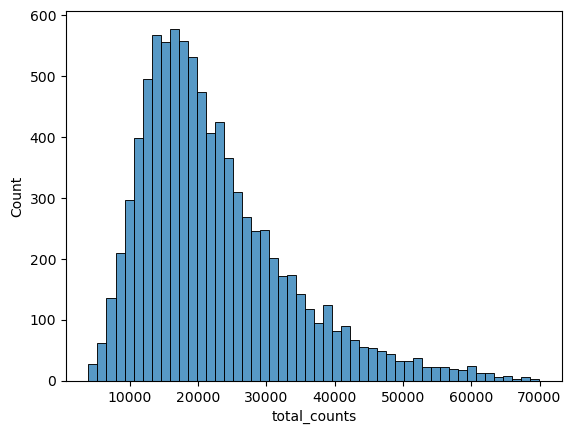

In [47]:
sns.histplot(filtered_combined_adata.obs['total_counts'], bins=50)

In [48]:
filtered_combined_adata.obs

,condition,pct_cmo,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo
barcode,,,,,,,,,,,,,,,,
AAACCCAGTAGGCTCC-1,CTRL_1,24.628355,3076,8.031710,15109,9.623112,41.683765,55.569528,65.404726,76.126812,324,5.783825,2.144417,6545,8.786609,43.318552
AAACCCAGTCGCAACC-1,CTRL_1,34.891727,4271,8.359837,18912,9.847605,38.055203,49.434222,57.741117,67.951565,354,5.872118,1.871827,7061,8.862484,37.336083
AAACCCATCCACAAGT-1,CTRL_1,23.580470,3517,8.165648,14791,9.601842,34.548036,45.101751,55.628423,68.643094,212,5.361292,1.433304,4165,8.334712,28.159016
AAACGCTTCACTACGA-1,CTRL_1,23.367459,4077,8.313362,18788,9.841027,37.710241,49.371940,58.888652,69.693421,479,6.173786,2.549500,6108,8.717518,32.510113
AAACGCTTCAGCCTCT-1,CTRL_1,24.847910,6263,8.742574,32489,10.388688,32.306319,43.494721,52.266921,62.778171,814,6.703188,2.505463,11026,9.308102,33.937640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGCAGCTACAT-1,TGFb1_GEM_2,34.726238,5677,8.644354,20994,9.952040,20.839287,28.088978,36.481852,50.161951,294,5.686975,1.400400,3246,8.085487,15.461560
TTTCACAGTGATATAG-1,TGFb1_GEM_2,12.793065,6177,8.728750,31691,10.363820,25.026033,35.167713,45.265217,58.628633,799,6.684612,2.521221,7761,8.956995,24.489603
TTTCACATCGATGCAT-1,TGFb1_GEM_2,50.637605,2748,7.918992,5458,8.605021,21.802858,29.443019,38.384023,53.023085,90,4.510860,1.648956,1070,6.976348,19.604251


In [49]:
filtered_combined_adata

View of AnnData object with n_obs × n_vars = 8901 × 36601
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo'
    uns: 'condition_colors'

### Filter: Doublet cell

In [50]:
sc.pp.filter_genes(filtered_combined_adata, min_cells=3)

# Entferne doppelte Zellen mit Scrublet
scrub = scr.Scrublet(filtered_combined_adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

# Füge die Scrublet-Ergebnisse zum AnnData-Objekt hinzu
filtered_combined_adata.obs['doublet_scores'] = doublet_scores
filtered_combined_adata.obs['predicted_doublets'] = predicted_doublets

# Entferne vorhergesagte doppelte Zellen
filtered_combined_adata = filtered_combined_adata[~filtered_combined_adata.obs['predicted_doublets']]


/home/s468630/micromamba/envs/scAnalysis/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 2.6%
Estimated detectable doublet fraction = 46.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.5%
Elapsed time: 11.5 seconds


In [51]:
filtered_combined_adata

View of AnnData object with n_obs × n_vars = 8674 × 26342
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells'
    uns: 'condition_colors'

### Filter outlier cells

In [52]:
# Define the function to check outliers
def is_outlier(filtered_combined_adata, metric: str, nmads: int):
    M = filtered_combined_adata.obs[metric]
    outlier = (M < np.median(M) - nmads * np.median(np.abs(M - np.median(M)))) | (
        np.median(M) + nmads * np.median(np.abs(M - np.median(M))) < M
    )
    return outlier


# Apply the outlier function to create a new column 'outlier' in adata.obs
filtered_combined_adata.obs["outlier"] = (
    is_outlier(filtered_combined_adata, "log1p_total_counts", 5)
    | is_outlier(filtered_combined_adata, "log1p_n_genes_by_counts", 5)
)

# Count the number of outliers
outlier_counts = filtered_combined_adata.obs.outlier.value_counts()
print(outlier_counts)


outlier
False    8672
True        2
Name: count, dtype: int64


/tmp/ipykernel_396581/4225883344.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  filtered_combined_adata.obs["outlier"] = (


In [53]:
# Filterung basierend auf Ausreißern in outlier und mt_outlier Spalten
outlier_filter = ~(filtered_combined_adata.obs["outlier"] )
adata_filtered = filtered_combined_adata[outlier_filter].copy()

# Überprüfen der Anzahl der verbleibenden Zellen nach der Filterung
print(f"Number of cells after filtering of low quality cells: {adata_filtered.n_obs}")

Number of cells after filtering of low quality cells: 8672


In [54]:
adata_filtered

AnnData object with n_obs × n_vars = 8672 × 26342
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells'
    uns: 'condition_colors'

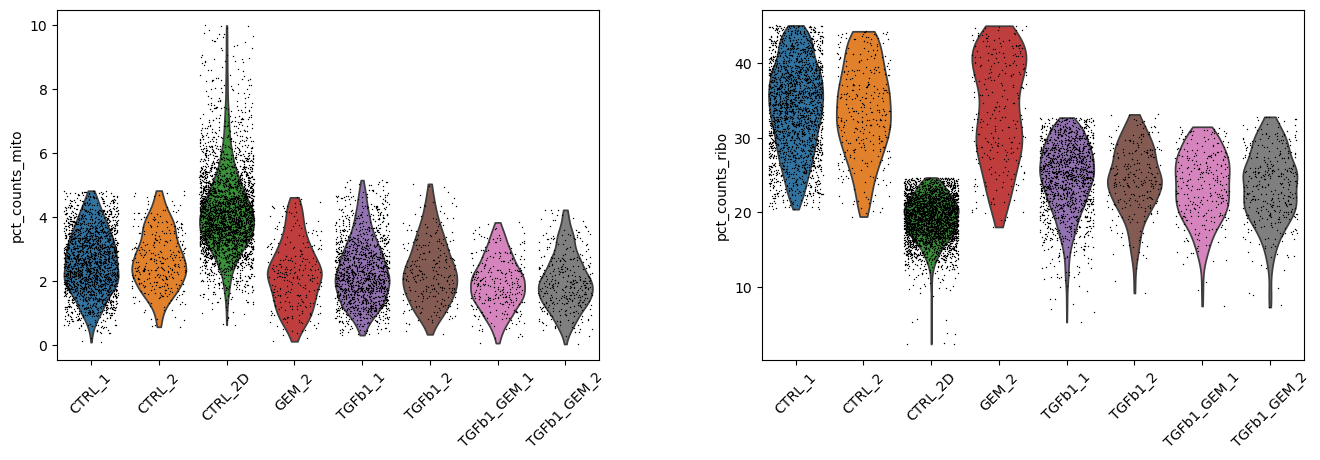

In [55]:
sc.pl.violin(
    filtered_combined_adata,
    keys=['pct_counts_mito', 'pct_counts_ribo'],
    groupby='condition',
    jitter=0.4,
    rotation=45,
    stripplot=True,
    multi_panel=True,
    save='violin_mito_ribo.png'  # Save the plot as an image
)
plt.show()

### Normalization

In [56]:
# You can use the median or mean total count across all cells as the target_sum. This ensures that the normalization doesn't excessively scale up very low-count cells or scale down very high-count cells.
#mean_counts = adata_filtereda.obs['total_counts'].mean()
median_counts = adata_filtered.obs['total_counts'].median()
median_counts

np.float64(19733.5)

In [57]:
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
#sc.pp.normalize_total(adata_filtered, target_sum=median_counts)

In [58]:
adata_filtered

AnnData object with n_obs × n_vars = 8672 × 26342
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells'
    uns: 'condition_colors'

### Log transformation

In [59]:
# Check for large integers (e.g., > 50) in the data matrix
large_integers = (adata_filtered.X > 50).sum()
if large_integers > 0:
    print("please logtransform again.")
else:
    print("Data seems to be already log-transformed. No transformation applied.")

please logtransform again.


In [60]:
sc.pp.log1p(adata_filtered)

In [61]:
adata_filtered

AnnData object with n_obs × n_vars = 8672 × 26342
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells'
    uns: 'condition_colors', 'log1p'

### Dimension Reduction

In [62]:
# Calculate PCA
sc.tl.pca(adata_filtered)

# Compute neighbors
sc.pp.neighbors(adata_filtered)

# Calculate clustering
sc.tl.leiden(adata_filtered)  # or sc.tl.louvain(adata)

# Compute UMAP (Optional)
sc.tl.umap(adata_filtered)

/tmp/ipykernel_396581/4138646809.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filtered)  # or sc.tl.louvain(adata)


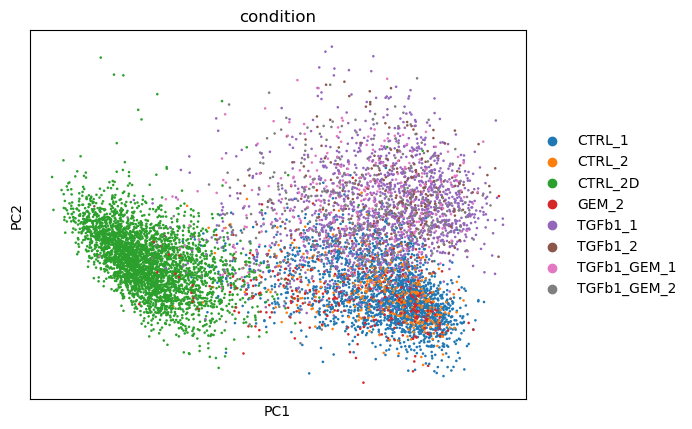

In [63]:
sc.pl.pca(adata_filtered, color='condition')

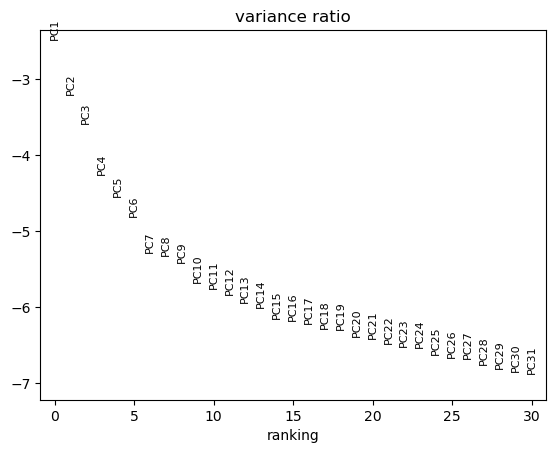

In [64]:
sc.pl.pca_variance_ratio(adata_filtered, log=True)

### Save filtered and normalized file

In [70]:
# Save adata --> here ID ensg number_for pseudotime
adata_filtered.write('/storage/users/data/PANC/H5AD_file/IV_adata_filtered.h5ad')

In [71]:
adata_filtered = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered.h5ad') 

## Remove 2D condition 

In [72]:
print(adata_filtered.shape)

(8672, 26342)


In [73]:
# Apply filtering
adata_filtered_no2D = adata_filtered[adata_filtered.obs['condition'] != 'CTRL_2D'].copy()

In [74]:
adata_filtered.obs['condition']

barcode
AAACCCAGTAGGCTCC-1         CTRL_1
AAACCCAGTCGCAACC-1         CTRL_1
AAACCCATCCACAAGT-1         CTRL_1
AAACGCTTCACTACGA-1         CTRL_1
AAAGAACAGATACAGT-1         CTRL_1
                         ...     
TTTACTGCAGCTACAT-1    TGFb1_GEM_2
TTTCACAGTGATATAG-1    TGFb1_GEM_2
TTTCACATCGATGCAT-1    TGFb1_GEM_2
TTTCATGTCCCTCTAG-1    TGFb1_GEM_2
TTTGACTGTTCCGGTG-1    TGFb1_GEM_2
Name: condition, Length: 8672, dtype: category
Categories (8, object): ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']

In [75]:
print(adata_filtered_no2D.shape)

(5257, 26342)


### Remove zero columns

In [76]:
import numpy as np
from scipy.sparse import issparse

# Check if the matrix is sparse
if issparse(adata_filtered_no2D.X):
    zero_count = adata_filtered_no2D.X.size - adata_filtered_no2D.X.nnz
else:
    zero_count = np.count_nonzero(adata_filtered_no2D.X == 0)

total_elements = adata_filtered_no2D.X.shape[0] * adata_filtered_no2D.X.shape[1]
print(f"Total number of zeros: {zero_count}")
print(f"Percentage of zeros: {zero_count / total_elements * 100:.2f}%")

# Check for entirely zero rows or columns
if issparse(adata_filtered_no2D.X):
    zero_rows = np.squeeze(np.array((adata_filtered_no2D.X.sum(axis=1) == 0)))
    zero_cols = np.squeeze(np.array((adata_filtered_no2D.X.sum(axis=0) == 0)))
else:
    zero_rows = np.all(adata_filtered_no2D.X == 0, axis=1)
    zero_cols = np.all(adata_filtered_no2D.X == 0, axis=0)

print("Number of completely zero rows: ", np.sum(zero_rows))
print("Number of completely zero columns: ", np.sum(zero_cols))

Total number of zeros: 0
Percentage of zeros: 0.00%
Number of completely zero rows:  0
Number of completely zero columns:  346


In [77]:
# Optionally, filter out zero rows and columns
if np.sum(zero_rows) > 0:
    adata_filtered_no2D = adata_filtered_no2D[~zero_rows, :]
if np.sum(zero_cols) > 0:
    adata_filtered_no2D = adata_filtered_no2D[:, ~zero_cols]

In [78]:
print(adata_filtered.shape)

(8672, 26342)


In [79]:
print(adata_filtered_no2D.shape)

(5257, 25996)


In [80]:
print(adata_filtered.obs['condition'].unique())  # Before filtering
print(adata_filtered_no2D.obs['condition'].unique())  # After filtering

['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']
Categories (8, object): ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']
['CTRL_1', 'CTRL_2', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']
Categories (7, object): ['CTRL_1', 'CTRL_2', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']


### Recomputing Metrics and Dimensionality Reduction After Data Filtering in Scanpy

### Save

In [81]:
# Save adata --> here ID ensg number_for pseudotime
adata_filtered_no2D.write('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D.h5ad')

In [19]:
adata_filtered_no2D = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D.h5ad') 

In [20]:
# Calculate PCA
sc.tl.pca(adata_filtered_no2D)

# Compute neighbors
sc.pp.neighbors(adata_filtered_no2D)

# Calculate clustering
sc.tl.leiden(adata_filtered_no2D)  # or sc.tl.louvain(adata)

# Compute UMAP (Optional)
sc.tl.umap(adata_filtered_no2D)


/tmp/ipykernel_402049/4020859461.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filtered_no2D)  # or sc.tl.louvain(adata)


## Highly Variable Gene Selection on adata_filtered_no2D

/home/s468630/micromamba/envs/scAnalysis/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


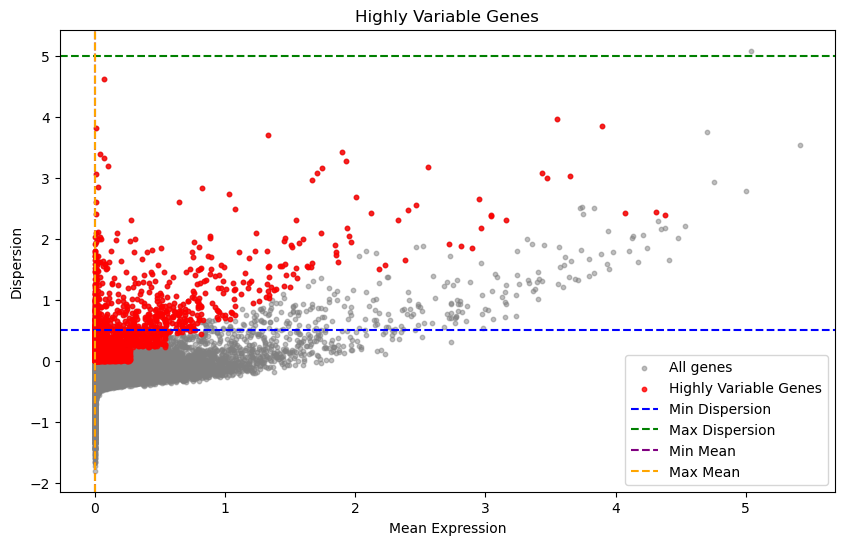

In [21]:
import matplotlib.pyplot as plt

# Compute highly variable genes
sc.pp.highly_variable_genes(
    adata_filtered_no2D,
    n_top_genes=2000,
    min_mean=-2e-5,
    max_mean=5.3,
    min_disp=0.5,
    max_disp=5
)

# Extract information for plotting
means = adata_filtered_no2D.var['means']
dispersions = adata_filtered_no2D.var['dispersions']
highly_variable = adata_filtered_no2D.var['highly_variable']

# Plot mean vs dispersion
plt.figure(figsize=(10, 6))
plt.scatter(means, dispersions, c='gray', s=10, alpha=0.5, label="All genes")
plt.scatter(
    means[highly_variable],
    dispersions[highly_variable],
    c='red',
    s=10,
    alpha=0.8,
    label="Highly Variable Genes"
)
plt.axhline(y=0.5, color='blue', linestyle='--', label='Min Dispersion')
plt.axhline(y=5, color='green', linestyle='--', label='Max Dispersion')
plt.axvline(x=-2e-5, color='purple', linestyle='--', label='Min Mean')
plt.axvline(x=2e-5, color='orange', linestyle='--', label='Max Mean')

plt.xlabel("Mean Expression")
plt.ylabel("Dispersion")
plt.title("Highly Variable Genes")
plt.legend()
plt.show()


In [84]:
# Calculate means and inspect extreme values
gene_means = np.mean(adata_filtered_no2D.X, axis=0).A1 if issparse(adata_filtered_no2D.X) else np.mean(adata_filtered_no2D.X, axis=0)
print("Max mean:", np.max(gene_means))
print("Min mean:", np.min(gene_means))

Max mean: 5.348100002167083
Min mean: 2.906125102446582e-05


In [91]:
#sc.pp.highly_variable_genes(adata_filtered_no2D,n_top_genes=4000)

In [22]:
# Determine a highly variable gene adata object
adata_filtered_no2D_hvg = adata_filtered_no2D[:, adata_filtered_no2D.var.highly_variable]

In [23]:
adata_filtered_no2D_hvg

View of AnnData object with n_obs × n_vars = 5257 × 2000
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Remove zero columns

In [21]:
import numpy as np
from scipy.sparse import issparse

# Check if the matrix is sparse
if issparse(adata_filtered_no2D_hvg.X):
    zero_count = adata_filtered_no2D_hvg.X.size - adata_filtered_no2D_hvg.X.nnz
else:
    zero_count = np.count_nonzero(adata_filtered_no2D_hvg.X == 0)

total_elements = adata_filtered_no2D_hvg.X.shape[0] * adata_filtered_no2D_hvg.X.shape[1]
print(f"Total number of zeros: {zero_count}")
print(f"Percentage of zeros: {zero_count / total_elements * 100:.2f}%")

# Check for entirely zero rows or columns
if issparse(adata_filtered_no2D_hvg.X):
    zero_rows = np.squeeze(np.array((adata_filtered_no2D_hvg.X.sum(axis=1) == 0)))
    zero_cols = np.squeeze(np.array((adata_filtered_no2D_hvg.X.sum(axis=0) == 0)))
else:
    zero_rows = np.all(adata_filtered_no2D_hvg.X == 0, axis=1)
    zero_cols = np.all(adata_filtered_no2D_hvg.X == 0, axis=0)

print("Number of completely zero rows: ", np.sum(zero_rows))
print("Number of completely zero columns: ", np.sum(zero_cols))

Total number of zeros: 0
Percentage of zeros: 0.00%
Number of completely zero rows:  0
Number of completely zero columns:  0


In [22]:
# Optionally, filter out zero rows and columns
if np.sum(zero_rows) > 0:
    adata_filtered_no2D_hvg = adata_filtered_no2D_hvg[~zero_rows, :]
if np.sum(zero_cols) > 0:
    adata_filtered_no2D_hvg = adata_filtered_no2D_hvg[:, ~zero_cols]

In [23]:
print(adata_filtered.shape)

(8672, 26342)


In [24]:
print(adata_filtered_no2D.shape)

(5257, 25996)


In [25]:
print(adata_filtered_no2D_hvg.shape)

(5257, 2000)


### Recomputing Metrics and Dimensionality Reduction After Data Filtering in Scanpy

In [26]:
print(adata_filtered_no2D_hvg)


AnnData object with n_obs × n_vars = 5257 × 2000
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'condition_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


### save the data

In [ ]:
adata_filtered_no2D_hvg.write('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D_hvg.h5ad')

In [28]:
adata_filtered_no2D_hvg = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D_hvg.h5ad') 

In [29]:
adata_filtered_no2D = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D.h5ad') 

In [30]:
sc.pp.scale(adata_filtered_no2D_hvg, max_value=10)

In [ ]:
# Calculate PCA
sc.tl.pca(adata_filtered_no2D_hvg)

In [9]:
# Compute neighbors
sc.pp.neighbors(adata_filtered_no2D_hvg)

# Calculate clustering
sc.tl.leiden(adata_filtered_no2D_hvg)  # or sc.tl.louvain(adata)

# Compute UMAP (Optional)
sc.tl.umap(adata_filtered_no2D_hvg)

/tmp/ipykernel_409199/1754139663.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filtered_no2D_hvg)  # or sc.tl.louvain(adata)


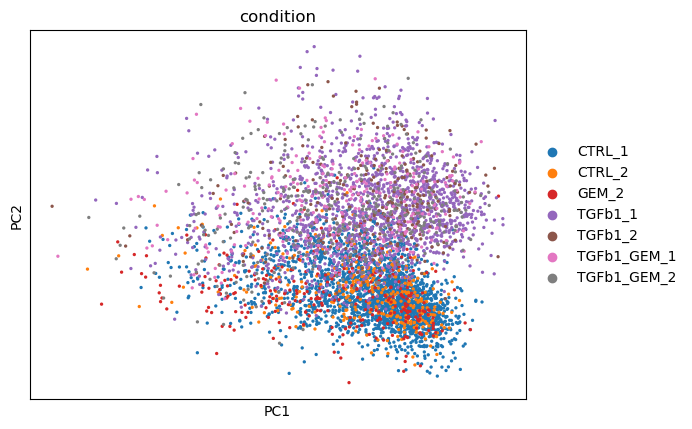

In [20]:
sc.pl.pca(adata_filtered_no2D, color='condition')

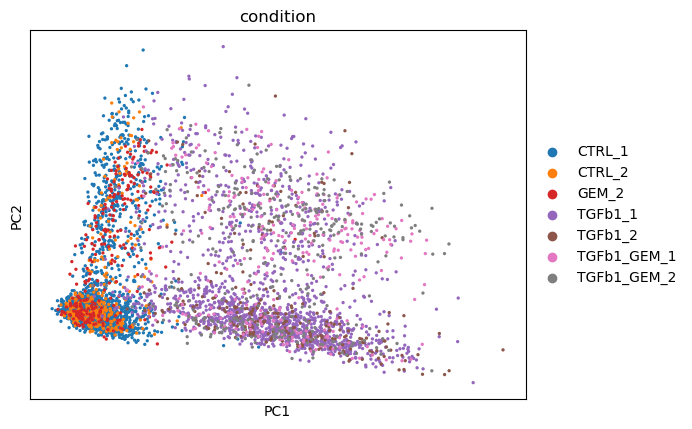

In [18]:
sc.pl.pca(adata_filtered_no2D_hvg, color='condition')

## Highly Variable Gene Selection on adata_filtered

In [8]:
adata_filtered = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered.h5ad')

In [9]:
adata_filtered

AnnData object with n_obs × n_vars = 8672 × 26342
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells'
    uns: 'condition_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
from scipy.sparse import issparse
import numpy as np

# Calculate means and inspect extreme values
gene_means = np.mean(adata_filtered.X, axis=0).A1 if issparse(adata_filtered.X) else np.mean(adata_filtered.X, axis=0)

print("Max mean:", np.max(gene_means))
print("Min mean:", np.min(gene_means))


Max mean: 5.2696592497142145
Min mean: 3.866397685212358e-05


In [12]:
# Identifying and focusing on highly variable genes improves the sensitivity of detecting cell populations.
sc.pp.highly_variable_genes(
    adata_filtered,
    n_top_genes=4000,
    min_mean=3e-05,  # Slightly below the min mean
    max_mean=5.3,   # Slightly above the max mean
    min_disp=0.5,    # Default dispersion threshold
    max_disp=5       # Default dispersion threshold
)

/home/s468630/micromamba/envs/scAnalysis/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


In [13]:
# Determine a highly variable gene adata object
adata_filtered_hvg = adata_filtered[:, adata_filtered.var.highly_variable]

In [14]:
adata_filtered_hvg

View of AnnData object with n_obs × n_vars = 8672 × 4000
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Remove zero columns

In [16]:
adata_filtered_no2D_hvg = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D_hvg.h5ad') 

In [22]:
adata_filtered_no2D = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_no2D.h5ad')

In [23]:
import numpy as np
from scipy.sparse import issparse

# Check if the matrix is sparse
if issparse(adata_filtered_hvg.X):
    zero_count = adata_filtered_hvg.X.size - adata_filtered_hvg.X.nnz
else:
    zero_count = np.count_nonzero(adata_filtered_hvg.X == 0)

total_elements = adata_filtered_hvg.X.shape[0] * adata_filtered_hvg.X.shape[1]
print(f"Total number of zeros: {zero_count}")
print(f"Percentage of zeros: {zero_count / total_elements * 100:.2f}%")

# Check for entirely zero rows or columns
if issparse(adata_filtered_no2D_hvg.X):
    zero_rows = np.squeeze(np.array((adata_filtered_no2D_hvg.X.sum(axis=1) == 0)))
    zero_cols = np.squeeze(np.array((adata_filtered_no2D_hvg.X.sum(axis=0) == 0)))
else:
    zero_rows = np.all(adata_filtered_no2D_hvg.X == 0, axis=1)
    zero_cols = np.all(adata_filtered_no2D_hvg.X == 0, axis=0)

print("Number of completely zero rows: ", np.sum(zero_rows))
print("Number of completely zero columns: ", np.sum(zero_cols))

Total number of zeros: 0
Percentage of zeros: 0.00%
Number of completely zero rows:  0
Number of completely zero columns:  0


In [24]:
# Optionally, filter out zero rows and columns
if np.sum(zero_rows) > 0:
    adata_filtered_no2D_hvg = adata_filtered_no2D_hvg[~zero_rows, :]
if np.sum(zero_cols) > 0:
    adata_filtered_no2D_hvg = adata_filtered_no2D_hvg[:, ~zero_cols]

In [25]:
print(adata_filtered.shape)

(8672, 26342)


In [26]:
print(adata_filtered_no2D.shape)

(5257, 25996)


In [27]:
print(adata_filtered_hvg.shape)

(8672, 4000)


In [28]:
print(adata_filtered_no2D_hvg.shape)

(5257, 2000)


### Recomputing Metrics and Dimensionality Reduction After Data Filtering in Scanpy

In [29]:
# Calculate PCA
sc.tl.pca(adata_filtered_hvg)

# Compute neighbors
sc.pp.neighbors(adata_filtered_hvg)

# Calculate clustering
sc.tl.leiden(adata_filtered_hvg)  # or sc.tl.louvain(adata)

# Compute UMAP (Optional)
sc.tl.umap(adata_filtered_hvg)


/home/s468630/micromamba/envs/scAnalysis/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/tmp/ipykernel_1399849/4143529904.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filtered_hvg)  # or sc.tl.louvain(adata)


/home/s468630/micromamba/envs/scAnalysis/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


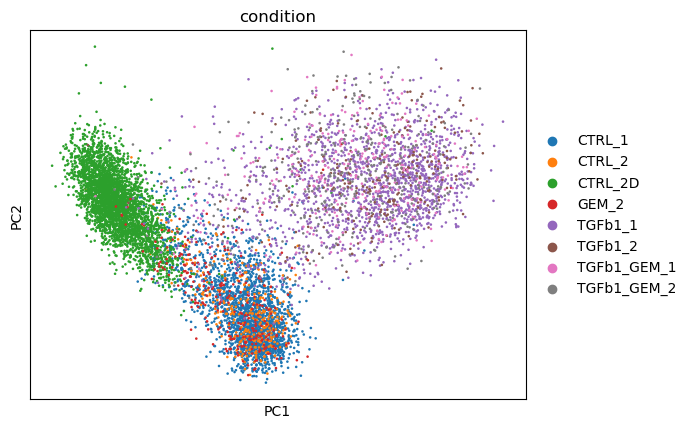

In [34]:
#sc.tl.pca(combined_adata)
sc.tl.pca(adata_filtered_hvg, use_highly_variable=False)
sc.pl.pca(adata_filtered_hvg, color='condition')

### Save the data

In [35]:
adata_filtered_hvg.write('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_hvg.h5ad')

In [ ]:
adata_filtered_hvg = sc.read('/storage/users/data/PANC/H5AD_file/IV_adata_filtered_hvg.h5ad') 